In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from IPython.display import Audio

In [2]:
TS_DATASET_FOLDER = os.path.join('..', 'dataset')
TS_PREPROC_FOLDER = os.path.join(TS_DATASET_FOLDER, 'preprocessed_traces')
DF_PREPROC_FILE = os.path.join(TS_PREPROC_FOLDER, 'preproc_ts.df')

SAMPLING_RATE = 48_000 / 8

import sys
sys.path.append('../')
import default_style

# This is for reloading custom modules in case they are modified
%load_ext autoreload
%autoreload 2

In [3]:
df = pd.read_csv(DF_PREPROC_FILE).drop(columns=['Unnamed: 0'])
df.head()

,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,path,sex,begin_s,end_s,fourier_coeffs,filtered_fourier_coeffs,syll_0_start_index,syll_1_start_index,syll_2_start_index,syll_3_start_index,syll_4_start_index,syll_5_start_index,syll_6_start_index,syll_7_start_index
0,speech,neutral,normal,kids,1st,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.009833,2.252000,[1.9371510e-07 1.2311488e-02 1.1168750e-02 ......,[1.9371510e-07 1.2311473e-02 1.1168692e-02 ......,0,1128,2240,3200,4304,5208,5808,7448
1,speech,neutral,normal,kids,2nd,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.068500,2.294667,[3.5017729e-07 2.6199006e-02 2.5683409e-02 ......,[3.5017729e-07 2.6198970e-02 2.5683273e-02 ......,0,2008,3208,3880,4224,5112,5800,7352
2,speech,neutral,normal,dogs,1st,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.012000,2.238500,[2.4959445e-07 1.2348385e-02 1.0678725e-02 ......,[2.49594450e-07 1.23483688e-02 1.06786685e-02 ...,0,2816,3352,3912,4296,5232,5880,7352
3,speech,neutral,normal,dogs,2nd,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.008833,2.187167,[1.1920929e-07 1.2154797e-02 1.6620804e-02 ......,[1.1920929e-07 1.2154780e-02 1.6620707e-02 ......,0,1664,2664,3208,3672,4840,5448,7064
4,speech,calm,normal,kids,1st,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.023667,2.534167,[1.1920929e-07 2.0026919e-03 7.9689088e-04 ......,[1.1920929e-07 2.0026902e-03 7.9688808e-04 ......,0,2088,3584,4832,5800,6944,7560,9056


In [4]:
## Import only the required stuff to prevent memory overload
traces_dict = dict()
for syll in [0,2]:
    file_path = os.path.join(TS_PREPROC_FOLDER, f"syllables_{syll}_ts.npy")
    traces_dict[f"syllables_{syll}_ts"] = np.load(file_path, allow_pickle=True)
# traces_dict["clean_trace"] = np.load( os.path.join(TS_PREPROC_FOLDER, "clean_trace.npy"), allow_pickle=True)
traces_dict.keys()

dict_keys(['syllables_0_ts', 'syllables_2_ts'])

In [5]:
traces_dict['syllables_0_ts'] = [ tr[~np.isnan(tr)] for tr in traces_dict['syllables_0_ts']]

Audio(traces_dict['syllables_0_ts'][0], rate=SAMPLING_RATE)

In [6]:
traces_dict['syllables_2_ts'] = [ tr[~np.isnan(tr)] for tr in traces_dict['syllables_2_ts']]

Audio(traces_dict['syllables_2_ts'][0], rate=SAMPLING_RATE)

In [7]:
# Concatenate syll0 and syll2
new_traces = [np.concatenate((traces_dict['syllables_0_ts'][i], traces_dict['syllables_2_ts'][i])) for i in range(len(traces_dict["syllables_0_ts"])) ]

Audio(new_traces[10], rate=SAMPLING_RATE)

1552


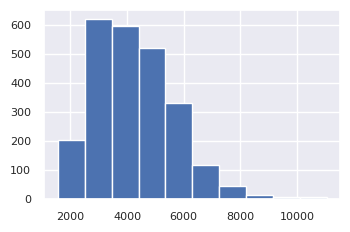

In [8]:
# Check distribution f lentgths
plt.hist([len(x) for x in new_traces]);
print(min([len(x) for x in new_traces]))

# Fourier stuff

In [9]:
from djanloo_fourier import STFTransformer

transf = STFTransformer(n_time_bins=None, 
                        n_spectral_bins=None, 
                        max_frequency=3000, 
                        sampling_rate=SAMPLING_RATE)

# Makes a square STFT
transf.balance_n_coeff(new_traces)
transf.report(new_traces)

shortest trace has length 1552
Time bins = 27, Spectral bins = 27
min length of window is roughly 57
max number of Fourier coeffs is 28


In [10]:
STFT, sc = transf.fit_transform(new_traces)

estimated max fourier  bins: 28


Transforming...: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 2452/2452 [00:57<00:00, 42.49it/s]


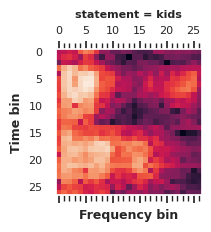

In [12]:
test_track_indx = 0
fig,ax = plt.subplots(figsize=default_style.SHORT_HALFSIZE_FIGURE)
ax.matshow(STFT[test_track_indx])
plt.grid(ls="")
plt.title(f"statement = {df.statement[test_track_indx]}")
plt.xlabel("Frequency bin")
plt.ylabel("Time bin")

plt.savefig("../images/stft_example_2.pdf")

In [12]:
np.save(os.path.join(TS_PREPROC_FOLDER, f"syllables_02_STFT.npy"), STFT)
np.save(os.path.join(TS_PREPROC_FOLDER, f"syllables_02_sc.npy"), sc)

## Check umap

In [13]:
from umap import UMAP

# Flattens each image
X = STFT.reshape(-1, transf.n_spectral_bins*transf.n_time_bins)

# Gets embedding
reducer = UMAP(n_neighbors=50, n_jobs=-1)
embedding = reducer.fit_transform(X)

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/djanloo/.local/share/virtualen

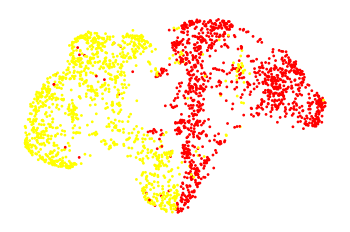

In [14]:
plt.scatter(*embedding.T, c=(df.statement=="dogs"), cmap="autumn", s=1)
plt.axis("off");
plt.savefig("../images/statement_umap.pdf")

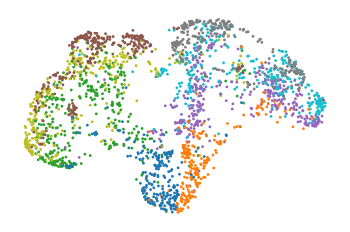

In [15]:
labels = [f"{row.sex}{row.vocal_channel}{row.statement}" for idx, row in df.iterrows()]
labels = pd.Categorical(labels).codes

plt.scatter(*embedding.T, c=labels, cmap="tab10", s=1)
plt.axis("off");
plt.savefig("../images/statement_sex_vc_umap.pdf")

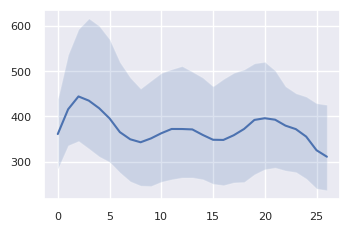

In [16]:
low, mid, up = np.quantile(sc,[0.25, 0.5, 0.75],axis=0)
plt.plot(mid)
plt.fill_between(range(len(up)), low, up, alpha=0.2)

## Test for increasing spectral resolution


Time bins = 50, Spectral bins = 50
min length of window is roughly 31
max number of Fourier coeffs is 15


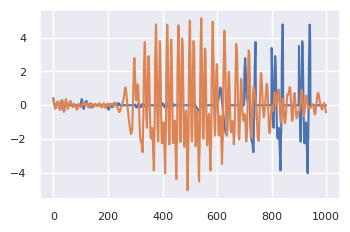

In [36]:
from djanloo_fourier import STFTransformer

transf = STFTransformer(n_time_bins=50, 
                        n_spectral_bins=50, 
                        max_frequency=3000, 
                        sampling_rate=SAMPLING_RATE)

# Makes a square STFT
# transf.balance_n_coeff(new_traces)
transf.report(new_traces)
padded_traces = transf.pad_traces(new_traces)
plt.plot(padded_traces[0][:1000])
plt.plot(new_traces[0][:1000])

In [37]:
STFT, sc = transf.fit_transform(padded_traces)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2452/2452 [03:17<00:00, 12.40it/s]


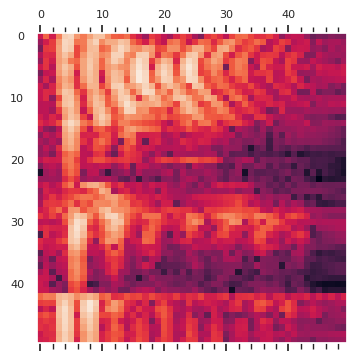

In [38]:
plt.matshow(STFT[test_track_indx])
plt.grid(ls="")